In [1]:
%run paper/setup.py

In [2]:
t, y = np.loadtxt('paper/data/6780873_lc.txt', usecols=(0,1)).T

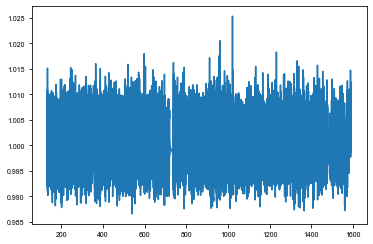

In [3]:
plt.plot(t,y)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x102df9748>,
      dtype=object)

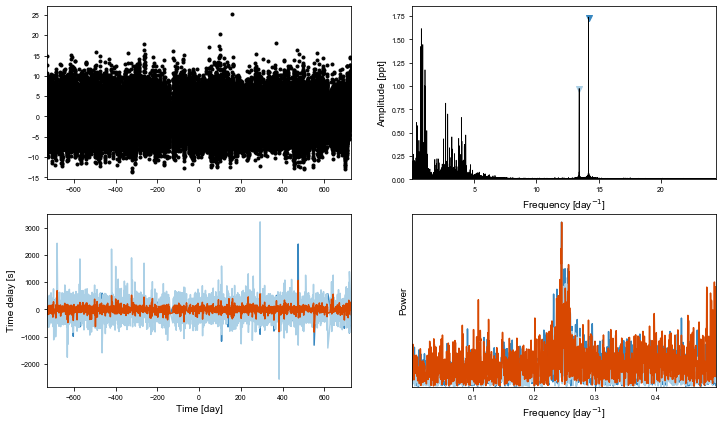

In [4]:
ms = Maelstrom(t, y, max_peaks=2, fmin=5, fmax=24)
ms.first_look(segment_size=1.)

In [5]:
import theano
def profile_model(model):
    with model:
        func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
    #     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
        args = xo.utils.get_args_for_theano_function(model.test_point)
        print(func(*args))
        %timeit func(*args)

In [6]:
period_guess = 9.158
a_guess = 17.23

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

In [7]:
ms.get_weights(norm=False)

array([1.73064022, 0.97161184])

In [9]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
from tqdm import tqdm

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = ((1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in tqdm(zip(self.freq, self.amplitude), total=len(self.freq)):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.sin(omega * (self.time - self.tau))# + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        s_rms = self.amplitude.max() / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

# Simulated

100%|██████████| 2/2 [00:00<00:00, 105.29it/s]


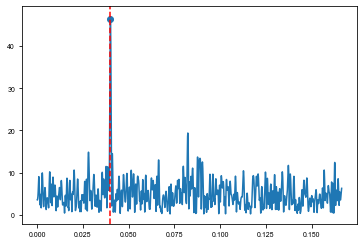

In [62]:
# from maelstrom.utils import amplitude_spectrum

# Fixed parameters
period_t = 25#9.159
eccen_t = 0.2
asini_t = 46
varpi_t = 0.
tref_t = 0.

#n_freq = 1
freqs = np.array([14.18764198, 13.43633836])
amps = np.array([1.73064022, 0.97161184])

# TESS 2 min cadence for 1 sector
# time = np.arange(0, 27, 1.0 / (24 * 30))
time = t

lc = SyntheticBinary(time, freqs, amps,
                     period_t, eccen_t, asini_t, varpi_t, tref_t)
np.random.seed(23)
lc.add_noise(snr=300)

ms = Maelstrom(lc.time, lc.flux / 1e3, freq=freqs)
from maelstrom.utils import amplitude_spectrum
a, b = ms.get_time_delay(segment_size=3)
b = np.average(b, axis=1, weights=ms.get_weights())
f,aa = amplitude_spectrum(a,b, fmin=1e-5)
plt.plot(f,aa)

#plt.xlim(0, 2*(1/period_t))
plt.axvline(1/period_t, c='r', linestyle='dashed')
#plt.xlim(200,1000)
#plt.xscale('log')
from scipy.signal import find_peaks
p = np.argmax(aa)
plt.scatter(f[p], aa[p])
period_guess, a_guess = 1/f[p], aa[p]

In [63]:
period_guess, a_guess

time, flux = ms.time, ms.flux

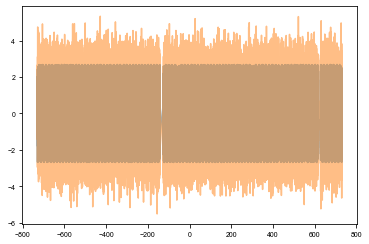

In [64]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

with pm.Model() as new_model:
    # Period
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1, shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=np.log(np.std(flux)))
    logasini = pm.Normal("logasini", mu=np.log(a_guess),sd=1,testval=np.log(a_guess)) 
    asini = pm.Deterministic("asini", tt.exp(logasini))
    omega = xo.distributions.Angle("omega")
    phi = xo.distributions.Angle("phi")
    eccen = pm.Uniform('eccen', lower=0., upper=0.9, testval=0.1)
    
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
   
    M = 2.0 * np.pi * time / period - phi
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = -(1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))
            
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    arg = 2. * np.pi * nu * (time[:, None] - ((asini) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, flux))
    pm.Deterministic('w', w)
    lc_model = tt.dot(D, w)
    full_lc = lc_model + mean
    # GP parameters
#     logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
#     pm.Potential("obs", gp.log_likelihood(flux - full_lc))
    pm.Normal('obs', mu =full_lc, sd=tt.exp(logs_lc), observed=flux)
    plt.plot(time, xo.eval_in_model(full_lc), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

In [ ]:
with new_model:
    all_but = [v for v in new_model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

[logP, logs_lc, logasini, omega_angle__, phi_angle__, eccen_interval__, mean, lognu]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -99532.9800230295 -> -99532.97470064863
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -99532.97470064863 -> -79781.30997103533
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -79781.30997103533 -> -79752.93213818352
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -79752.93213818352 -> -79732.47459857132
optimizing logp for variables: ['lognu']
message: Desired error not necessarily achieved due to precision loss.
logp: -79732.47459857132 -> -79731.3933749408
optimizing logp for variables: ['lognu', 'mean', 'eccen_interval__', 'phi_angle__', 'omega_angle__', 'logasini', 'logs_lc', 'logP']


In [61]:
map_params

{'logP': array([3.91045218]),
 'logs_lc': array(-0.18803984),
 'logasini': array(3.96627676),
 'omega_angle__': array([ 0.61326205, -4.42988815]),
 'phi_angle__': array([-4.46536969,  0.2459056 ]),
 'eccen_interval__': array(-1.00859699),
 'mean': array(-0.00061462),
 'lognu': array([2.6523714 , 2.59796295]),
 'period': array([49.92152021]),
 'asini': array(52.78762337),
 'omega': array(3.00402963),
 'phi': array(-1.51578241),
 'eccen': array(0.24052906),
 'nu': array([14.18764334, 13.43633961]),
 'w': array([1.65966906, 0.74123239, 0.48565078, 0.62658865])}

# Periodogram

In [23]:
pg = ms.period_search()

In [27]:
periods = np.linspace(2, 15, 200)
results = pg.fit(periods)


100%|██████████| 200/200 [05:47<00:00,  1.67s/it]

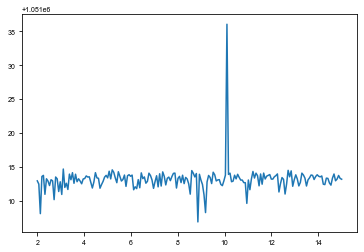

In [33]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods, -sm);

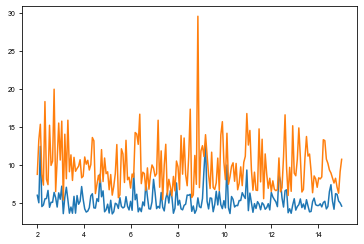

In [29]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
plt.plot(periods, ys.T);

# Subdividing model

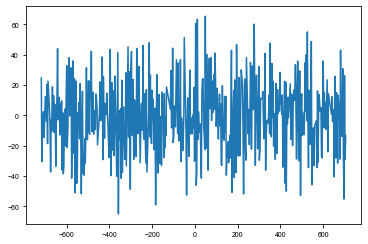

In [7]:
td_time, td_td = np.loadtxt('paper/data/kic6780873_time-delay_Q99_llc.txt', delimiter=',', usecols=(0,1)).T
td_time += 2400000
td_time -= 2454833
#td_time -= np.median(td_time)
td_time = td_time[td_td< 70]
td_td = td_td[td_td < 70]

td_time = td_time[td_td>- 70]
td_td = td_td[td_td>-70]

td_time -= np.median(td_time)
plt.plot(td_time, td_td)

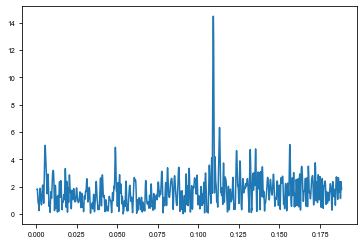

In [8]:
from maelstrom.utils import amplitude_spectrum
plt.plot(*amplitude_spectrum(td_time, td_td))

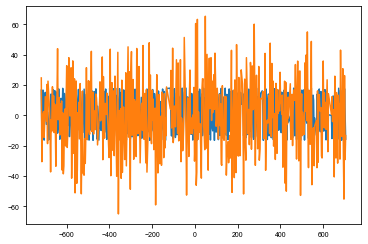

In [9]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1e-3, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=10, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
#     omega = xo.distributions.Angle("omega", testval=0.)
#     phi = xo.distributions.Angle("phi", testval=0.22)
    omega = xo.distributions.Periodic("omega", lower=4.36-np.pi, upper=4.36+np.pi)
    phi = xo.distributions.Periodic("phi", lower=6-np.pi, upper=6+np.pi)
#     omega = pm.Uniform("omega", lower=-2*np.pi, upper=2*np.pi)
    mean = pm.Normal('mean', mu=0, sd=5, testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.99, testval=0.05)
#     BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
#     eccen = BoundedBeta("eccen", alpha=0.867, beta=3.03, shape=1,
#                           testval=0.05)
    # The baseline flux
    #mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - mean)
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

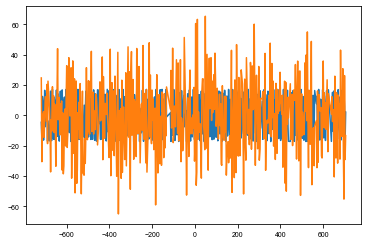

In [10]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1e-3, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=10, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    phi = xo.distributions.Angle("phi", testval=0.22)
#     sinomega = pm.Uniform('sinomega', lower=-1, upper=1)
#     sinphi = pm.Uniform("sinphi", lower=-1, upper=1)
#     omega = pm.Uniform("omega", lower=-2*np.pi, upper=2*np.pi)
    mean = pm.Normal('mean', mu=0, sd=5, testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.99, testval=0.05)
#     BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
#     eccen = BoundedBeta("eccen", alpha=0.867, beta=3.03, shape=1,
#                           testval=0.05)
    # The baseline flux
    #mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - mean)
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

In [11]:
with subdivide_model:
    map_params = xo.optimize(vars=[mean])
    map_params = xo.optimize(vars=[logs_lc])
    map_params = xo.optimize(vars=[logasini, phi])

    map_params = xo.optimize(vars=[logs_lc])

    map_params = xo.optimize(vars=[eccen, omega])

    map_params = xo.optimize(vars=[logP])

    map_params = xo.optimize()



optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -168160.4782163282 -> -168058.72943253058
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -168160.4782163282 -> -2358.913465737587
optimizing logp for variables: ['phi_angle__', 'logasini']
message: Optimization terminated successfully.
logp: -168160.4782163282 -> -109718.0420000652
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -168160.4782163282 -> -2358.913465737587
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -168160.4782163282 -> -110660.3589525119
optimizing logp for variables: ['logP']
message: Desired error not necessarily achieved due to precision loss.
logp: -168160.4782163282 -> -165248.45287471524
optimizing logp for variables: ['eccen_interval__', 'mean', 'phi_angle__', 'omega_angle__', 

In [12]:
map_params

{'logP': array(2.21443641),
 'logs_lc': array(3.030911),
 'logasini': array(2.68758733),
 'drift': array(0.00188251),
 'omega_angle__': array([-4.44445675,  0.49679312]),
 'phi_angle__': array([1.08405869, 4.33875763]),
 'mean': array(6.05476115),
 'eccen_interval__': array(-1.1228673),
 'period': array(9.15624729),
 'asini': array(14.69617613),
 'omega': array(-1.45948026),
 'phi': array(0.24484184),
 'eccen': array(0.24302502),
 'taumodel': array([ 10.42959237,  -7.8903602 , -12.37308171,   9.54112603,
          3.15965082, -18.4599065 ,   2.39994257,   9.75495589,
         -9.44569251,  10.36770511,   0.86335982, -17.80880009,
          1.93635228, -18.45247336,   3.74549946,   9.25904586,
         -4.63464271,  -0.74622149,  10.65682765,  -7.06366524,
        -12.96001021,   9.38647567,   3.65809352, -18.27808094,
          2.06282998,  10.01349565, -10.0702798 ,  -9.88556181,
         10.353044  ,   1.4131478 , -18.2861435 ,   3.99743586,
          7.7177406 , -15.13900513,  -3.83

In [23]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with subdivide_model:
    burnin = sampler.tune(tune=2000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 4 chains: 100%|██████████| 2008/2008 [00:05<00:00, 336.38draws/s]


In [24]:
with subdivide_model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eccen, mean, phi, omega, drift, logasini, logs_lc, logP]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:22<00:00, 357.34draws/s]
The number of effective samples is smaller than 25% for some parameters.


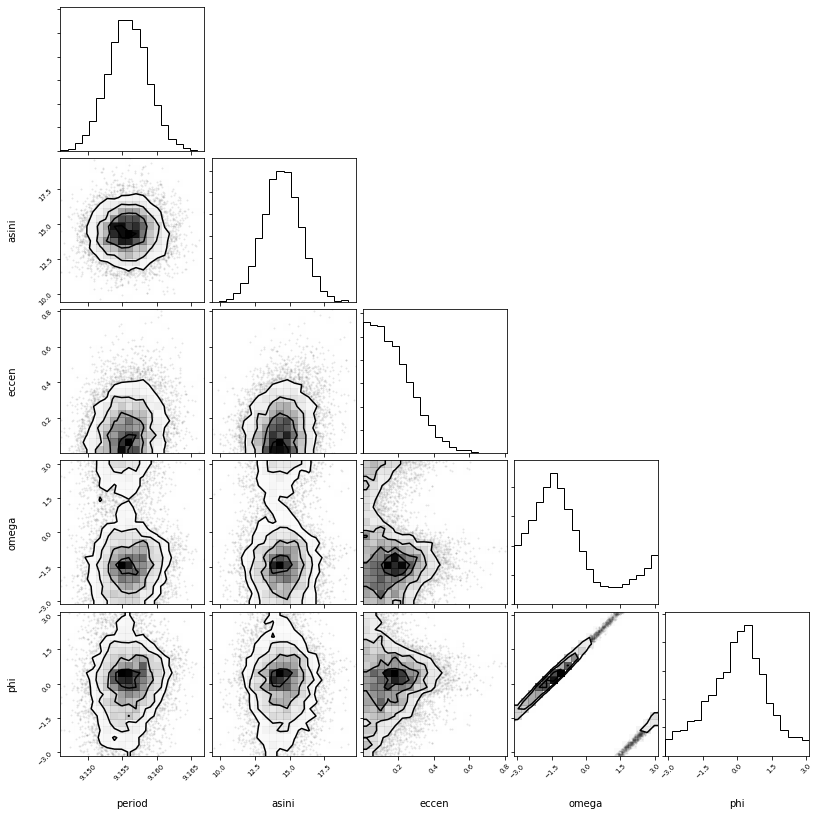

In [26]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'eccen', 'omega', 'phi']));

In [27]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.039  +  0.012  -  0.01


In [28]:
phis = trace['omega']
phis[phis < 0] += 2*np.pi
np.median(phis)

upper, med, lower = np.percentile(phis, [84.13, 50, 15.86])
print(': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

:  4.395  +  1.06  -  1.872


In [30]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  9.156  +  0.003  -  0.003
phi :  0.105  +  1.112  -  1.421
eccen :  0.15  +  0.145  -  0.104
asini :  14.433  +  1.332  -  1.358
omega :  -1.202  +  2.278  -  1.098


In [35]:
pm.save_trace(trace, 'traces/6780873_subdivided_final/', overwrite=True)

'traces/6780873_subdivided_final/'

Text(0, 0.5, 'Time delay (s)')

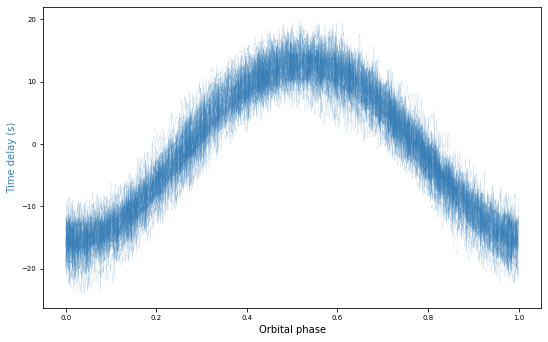

In [37]:

fig, ax = plt.subplots(figsize=mnras_size(540), constrained_layout=True)

with subdivide_model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        #taumod = xo.eval_in_model(asini * psi, samp)
        ttime = (td_time) % samp['period'] / samp['period']
        tau = samp['taumodel']
        
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], tau[sort], linewidth=0.1, alpha=1, color=blue)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        #ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        #sort = np.argsort(ttime)
        #ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True)
        
    
#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

#ax.set_xlim(0, 1)

#plt.savefig(overleaf_path + '6780873.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [7]:
a_guess

17.23

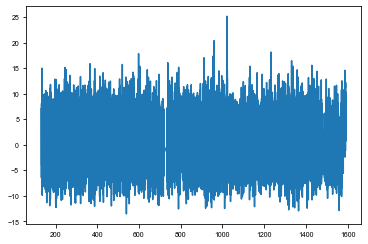

In [14]:
plt.plot(time + ms.time_mid, flux)

In [15]:
time += ms.time_mid

# Maelstrom

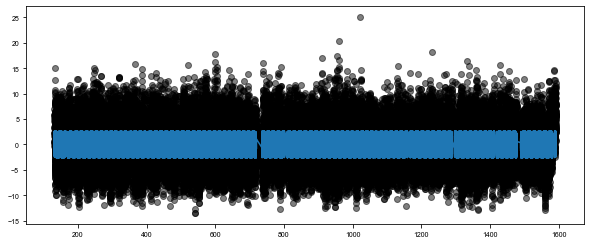

In [16]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi", testval=5.93)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(a_guess), sd=1,
                                            testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
#     asini = pm.Uniform('asini', lower=-50, upper=50)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=4.45)
    #omega = pm.Uniform("omega", lower=0, upper=2*np.pi)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.1)

    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
                
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = -((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_mean_amp = np.log(ms.get_weights(norm=False))
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
#     logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    
    
#     pm.Potential("obs", gp.log_likelihood(flux - full_lc))
    pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
    #trace = pm.load_trace('traces/6780873_FINAL_VERSION/')
    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,flux, c='black', alpha=0.5)

[phi_angle__, logs_lc, mean, omega_angle__, eccen_interval__, lognu, phase_angle__, logamp]


optimizing logp for variables: [mean]
5it [00:00, 38.05it/s, logp=-5.638962e+05]
message: Optimization terminated successfully.
logp: -563896.3552244303 -> -563896.1769195145
optimizing logp for variables: [logs_lc]
150it [00:02, 51.91it/s, logp=-1.808859e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -563896.1769195145 -> -180885.86754399908
optimizing logp for variables: [logamp, phase]
225it [00:04, 46.91it/s, logp=-1.763349e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -180885.86754399908 -> -176334.88650611485
optimizing logp for variables: [omega, eccen]
19it [00:00, 41.24it/s, logp=-1.763134e+05]
message: Optimization terminated successfully.
logp: -176334.88650611485 -> -176313.38143537217
optimizing logp for variables: [phi]
77it [00:01, 45.84it/s, logp=-1.762929e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -176313.38143537217 -> -176292.8954374027
optimizing logp for va

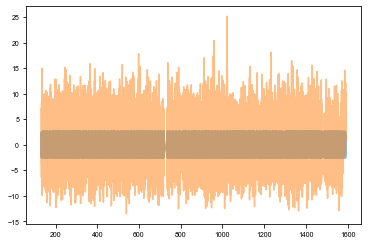

In [17]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

In [20]:
map_params

{'logP_interval__': array(-1.03303013),
 'phi_angle__': array([-1.36318688,  4.25931044]),
 'logs_lc': array(1.29764367),
 'logasini_interval__': array(-0.27482645),
 'mean': array(-0.00019797),
 'omega_angle__': array([-3.5681854 , -2.69593258]),
 'eccen_interval__': array(-0.08343465),
 'lognu': array([2.6523713 , 2.59796286]),
 'phase_angle__': array([[-1.89292336,  0.65370739],
        [ 4.05177008, -4.42410076]]),
 'logamp': array([ 0.54798953, -0.03055631]),
 'logP': array(2.21385976),
 'period': array(9.15096882),
 'phi': array(-0.30974714),
 'logasini': array(2.9974158),
 'asini': array(20.03369895),
 'omega': array(-2.21783822),
 'eccen': array(0.47867428),
 'nu': array([14.187642  , 13.43633841]),
 'phase': array([-0.43705214,  2.99489363])}

In [18]:
with model:
    med = xo.eval_in_model(gp.predict() + full_lc, map_params)
#     lc_mod = xo.eval_in_model(full_lc, map_params)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


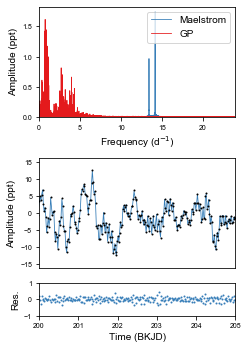

In [19]:
fig, axes = plt.subplots(3,1, figsize=[3.33333, 2.06*2.3], gridspec_kw={'height_ratios': [1,1,0.3]}, constrained_layout=True)
from maelstrom.utils import amplitude_spectrum
with model:
    ax = axes[0]
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)),
            c=blue, alpha=1, linewidth=0.8, label='Maelstrom')
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)),
            c=red, alpha=1, linewidth=0.8, label='GP')
    ax.set_xlim(0,24)
    ax.set_ylim(0, None)
    ax.legend()
    
    #ax.plot(*amplitude_spectrum(time, flux), alpha=0.2, c='green')
    
    ax.set_xlabel('Frequency (d$^{-1}$)')
    ax.set_ylabel('Amplitude (ppt)')
    
    
    ax = axes[1]
    ax.plot(time + ms.time_mid,med , c=blue, alpha=1, linewidth=0.8, rasterized=True)
    ax.plot(time + ms.time_mid, flux, '.k', markersize=2, rasterized=True)
    ax.set_xlim(200,205)
    ax.set_ylim(-16.2,16.2)
    ax.set_xticks([])
    ax.set_ylabel('Amplitude (ppt)')
    
    ax = axes[2]
    ax.plot(time + ms.time_mid, med - flux, '.k',
            c=blue, alpha=1, linewidth=0.7, label='Light curve model', markersize=2, rasterized=True)
    ax.set_xlim(200,205)
    ax.set_ylim(-1,1)
    ax.set_xlabel('Time (BKJD)')
    ax.set_ylabel('Res.')
    
# plt.savefig(overleaf_path + '6780873_lc_model.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [29]:
with model:
    trace = pm.load_trace('traces/6780873_FINAL_VERSION/')

/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


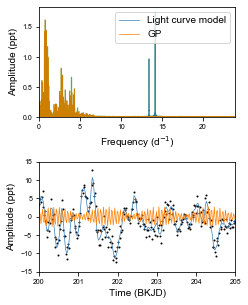

In [17]:
from maelstrom.utils import amplitude_spectrum
from maelstrom.utils import unique_colors

fig, axes = plt.subplots(2,1, figsize=[3.33333, 2.06*2], constrained_layout=True)

with model:
    ax = axes[1]
    ax.plot(time + ms.time_mid, flux, '.k', markersize=2)
    ax.plot(time + ms.time_mid, xo.eval_in_model(gp.predict(), map_params), c=blue, alpha=1, linewidth=0.7)
    ax.plot(time + ms.time_mid, xo.eval_in_model(full_lc, map_params), c=orange, alpha=1, linewidth=0.7)
    ax.set_xlim(200,205)
    ax.set_ylim(-15,15)
    ax.set_xlabel('Time (BKJD)')
    ax.set_ylabel('Amplitude (ppt)')
    
    ax = axes[0]
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)),
            c=blue, alpha=1, linewidth=0.7, label='Maelstrom')
    ax.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)),
            c=orange, alpha=1, linewidth=0.7, label='GP')
    ax.set_xlim(0,24)
    ax.set_ylim(0, None)
    ax.legend()
    
    ax.plot(*amplitude_spectrum(time, flux), alpha=0.2, c='green')
    
    ax.set_xlabel('Frequency (d$^{-1}$)')
    ax.set_ylabel('Amplitude (ppt)')

In [57]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 4 chains: 100%|██████████| 2008/2008 [12:38<00:00,  1.50draws/s]


In [58]:
with model:
    trace = sampler.sample(draws=1000)

Sampling 4 chains: 100%|██████████| 4000/4000 [20:12<00:00,  1.66draws/s]


In [60]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.308301,6.148774e-03,6.815556e-05,-1.320417,-1.296558,7979.089908,0.999781
mean,-0.222776,1.229104e-01,2.617794e-03,-0.462523,-0.002277,2234.967877,0.999650
boosting,0.341301,1.299696e-01,2.376803e-03,0.089525,0.599485,3034.107258,0.999637
lognu__0,2.652371,3.377686e-08,3.927461e-10,2.652371,2.652371,7082.184725,0.999813
lognu__1,2.597963,6.829287e-08,8.984059e-10,2.597963,2.597963,6232.865326,0.999810
logamp__0,0.549262,1.267608e-03,1.575682e-05,0.546855,0.551749,6200.126939,0.999599
logamp__1,-0.038317,2.437341e-03,2.843092e-05,-0.043080,-0.033669,6820.368119,0.999647
logpower,10.823018,9.522999e-03,1.164272e-04,10.804820,10.842032,7103.436941,0.999866
logP,2.214865,2.382775e-04,3.620303e-06,2.214378,2.215307,4279.195382,0.999630
period,9.160174,2.182592e-03,3.316057e-05,9.155708,9.164222,4279.462495,0.999630


In [39]:
full_model_vals = []
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=500):
        full_model_vals.append(xo.eval_in_model(gp.predict() + full_lc, samp))

In [40]:
sd = np.std(full_model_vals, axis=0)
med = np.median(full_model_vals, axis=0)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


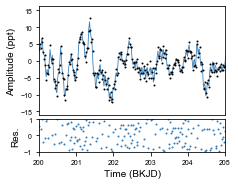

In [41]:
from maelstrom.utils import amplitude_spectrum

fig, axes = plt.subplots(2,1, figsize=[3.33333, 2.06*1.3], constrained_layout=True, gridspec_kw={'height_ratios':[1,0.3]})

with model:
    ax = axes[0]
    ax.plot(time + ms.time_mid,med , c=blue, alpha=1, linewidth=0.8, rasterized=True)
    ax.plot(time + ms.time_mid, flux, '.k', markersize=2, rasterized=True)
    #full_model_val = xo.eval_in_model(gp.predict() + full_lc, map_params)
    #ax.fill_between(time + ms.time_mid, med + sd*2, med - sd*2, alpha=1)
    #ax.plot(time + ms.time_mid, xo.eval_in_model(full_lc, map_params), c=green, alpha=0.5, linewidth=0.7)
    #ax.plot(time + ms.time_mid, xo.eval_in_model(gp.predict(), map_params), c='red', alpha=0.5, linewidth=0.7)
    ax.set_xlim(200,205)
    ax.set_ylim(-16.2,16.2)
    ax.set_xticks([])
    ax.set_ylabel('Amplitude (ppt)')
    
    ax = axes[1]
    ax.plot(time + ms.time_mid, med - flux, '.k',
            c=blue, alpha=1, linewidth=0.7, label='Light curve model', markersize=2, rasterized=True)
    ax.set_xlim(200,205)
    ax.set_ylim(-1,1)
    ax.set_xlabel('Time (BKJD)')
    ax.set_ylabel('Res.')
    plt.subplots_adjust(hspace=0.05)
    
#plt.savefig(overleaf_path + '6780873_lc_model.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [52]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.308072,6.218619e-03,1.073901e-04,-1.319758,-1.295172,3808.123162,0.999801
mean,0.007654,4.427092e-02,7.376930e-04,-0.077047,0.097591,3723.823709,0.999734
lognu__0,2.652371,3.251698e-08,5.638449e-10,2.652371,2.652371,3274.941545,0.999507
lognu__1,2.597963,6.917924e-08,1.136706e-09,2.597963,2.597963,3616.047248,0.999581
logpower,10.823058,9.786532e-03,1.475435e-04,10.804199,10.842390,3607.070047,0.999728
logP,2.214734,2.850301e-04,5.071652e-06,2.214194,2.215299,2880.604180,1.000441
period,9.158975,2.610583e-03,4.644844e-05,9.154031,9.164153,2880.613278,1.000440
phi,-1.045266,6.912440e-01,3.144468e-02,-2.419841,0.055176,298.418294,1.004736
logasini,2.925790,8.729998e-02,1.689740e-03,2.748015,3.086087,2376.702503,0.999509
asini,18.719303,1.608579e+00,3.033433e-02,15.611615,21.891254,2540.698503,0.999523


In [47]:
with model:
    trace = pm.load_trace('traces/6780873_FINAL_VERSION/')

In [53]:
pm.save_trace(trace,'traces/6780873_FINAL_VERSION')

'traces/6780873_FINAL_VERSION'

Text(0, 0.5, 'Time delay (s)')

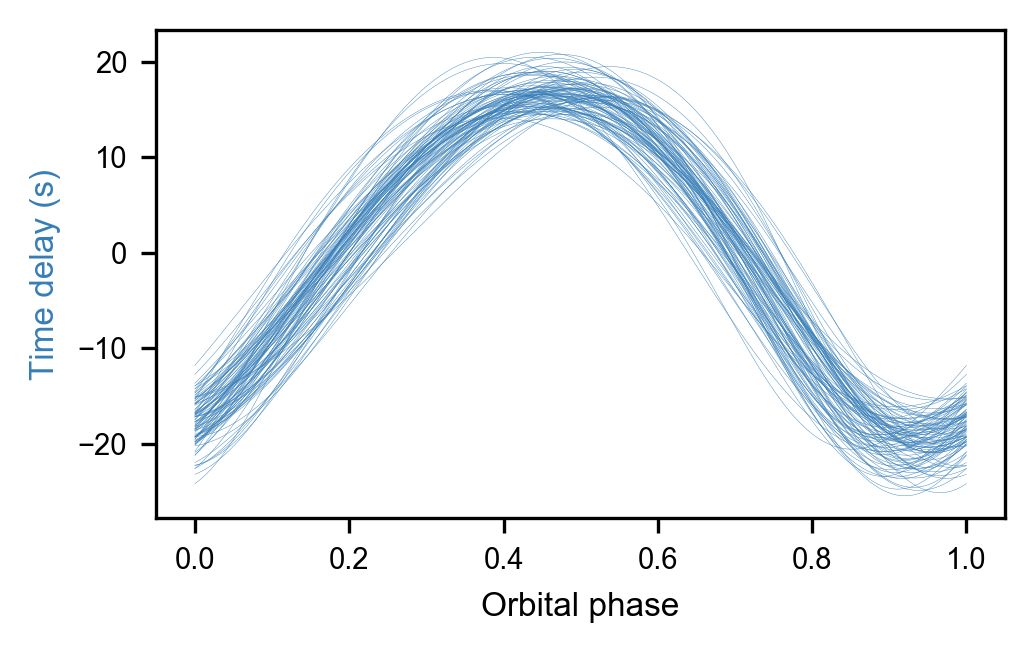

In [56]:

fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)

with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        taumod = xo.eval_in_model(asini * psi, samp)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True)
        
    

#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

#ax.set_xlim(0, 1)

#plt.savefig(overleaf_path + '6780873.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [170]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.085  +  0.023  -  0.02


In [171]:
mfs.unit.to_string('latex')

'$\\mathrm{M_{\\odot}}$'

In [174]:
varnames=['period', 'asini', 'phi', 'eccen', 'omega', 'logw0', 'logS0']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  9.159  +  0.002  -  0.003
phi :  -1.066  +  0.468  -  0.533
eccen :  0.243  +  0.043  -  0.094
asini :  18.773  +  1.559  -  1.578
omega :  -2.031  +  0.555  -  0.514
logw0 :  2.628  +  0.006  -  0.006
logS0 :  0.311  +  0.021  -  0.02


In [58]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,5.606935,1.455171e-03,2.357832e-05,5.604220,5.609866,4091.469425,0.999521
logs_lc,0.043440,2.911789e-03,4.081594e-05,0.037475,0.049095,6147.357943,0.999501
logasini,5.221483,1.881522e-02,3.927483e-04,5.184861,5.256568,2911.774883,0.999547
mean,0.013216,2.686770e-02,3.764529e-04,-0.038528,0.065928,4646.295234,0.999502
lognu__0,2.969269,6.509594e-08,9.686273e-10,2.969269,2.969269,5160.519116,0.999713
lognu__1,3.077871,1.320127e-07,2.174085e-09,3.077871,3.077872,3652.595458,1.000236
lognu__2,3.427576,1.065142e-07,1.753995e-09,3.427576,3.427577,4434.063600,0.999800
lognu__3,2.873532,2.195352e-07,3.412605e-09,2.873531,2.873532,4067.270551,0.999634
lognu__4,3.122114,1.894470e-07,2.885338e-09,3.122113,3.122114,5141.247309,0.999673
logpower,-3.030173,1.011850e-01,1.450748e-03,-3.228666,-2.829699,5537.624795,0.999838


In [54]:
ax.collections

[]

In [50]:
np.shape(all_times
        )

(300, 65266)

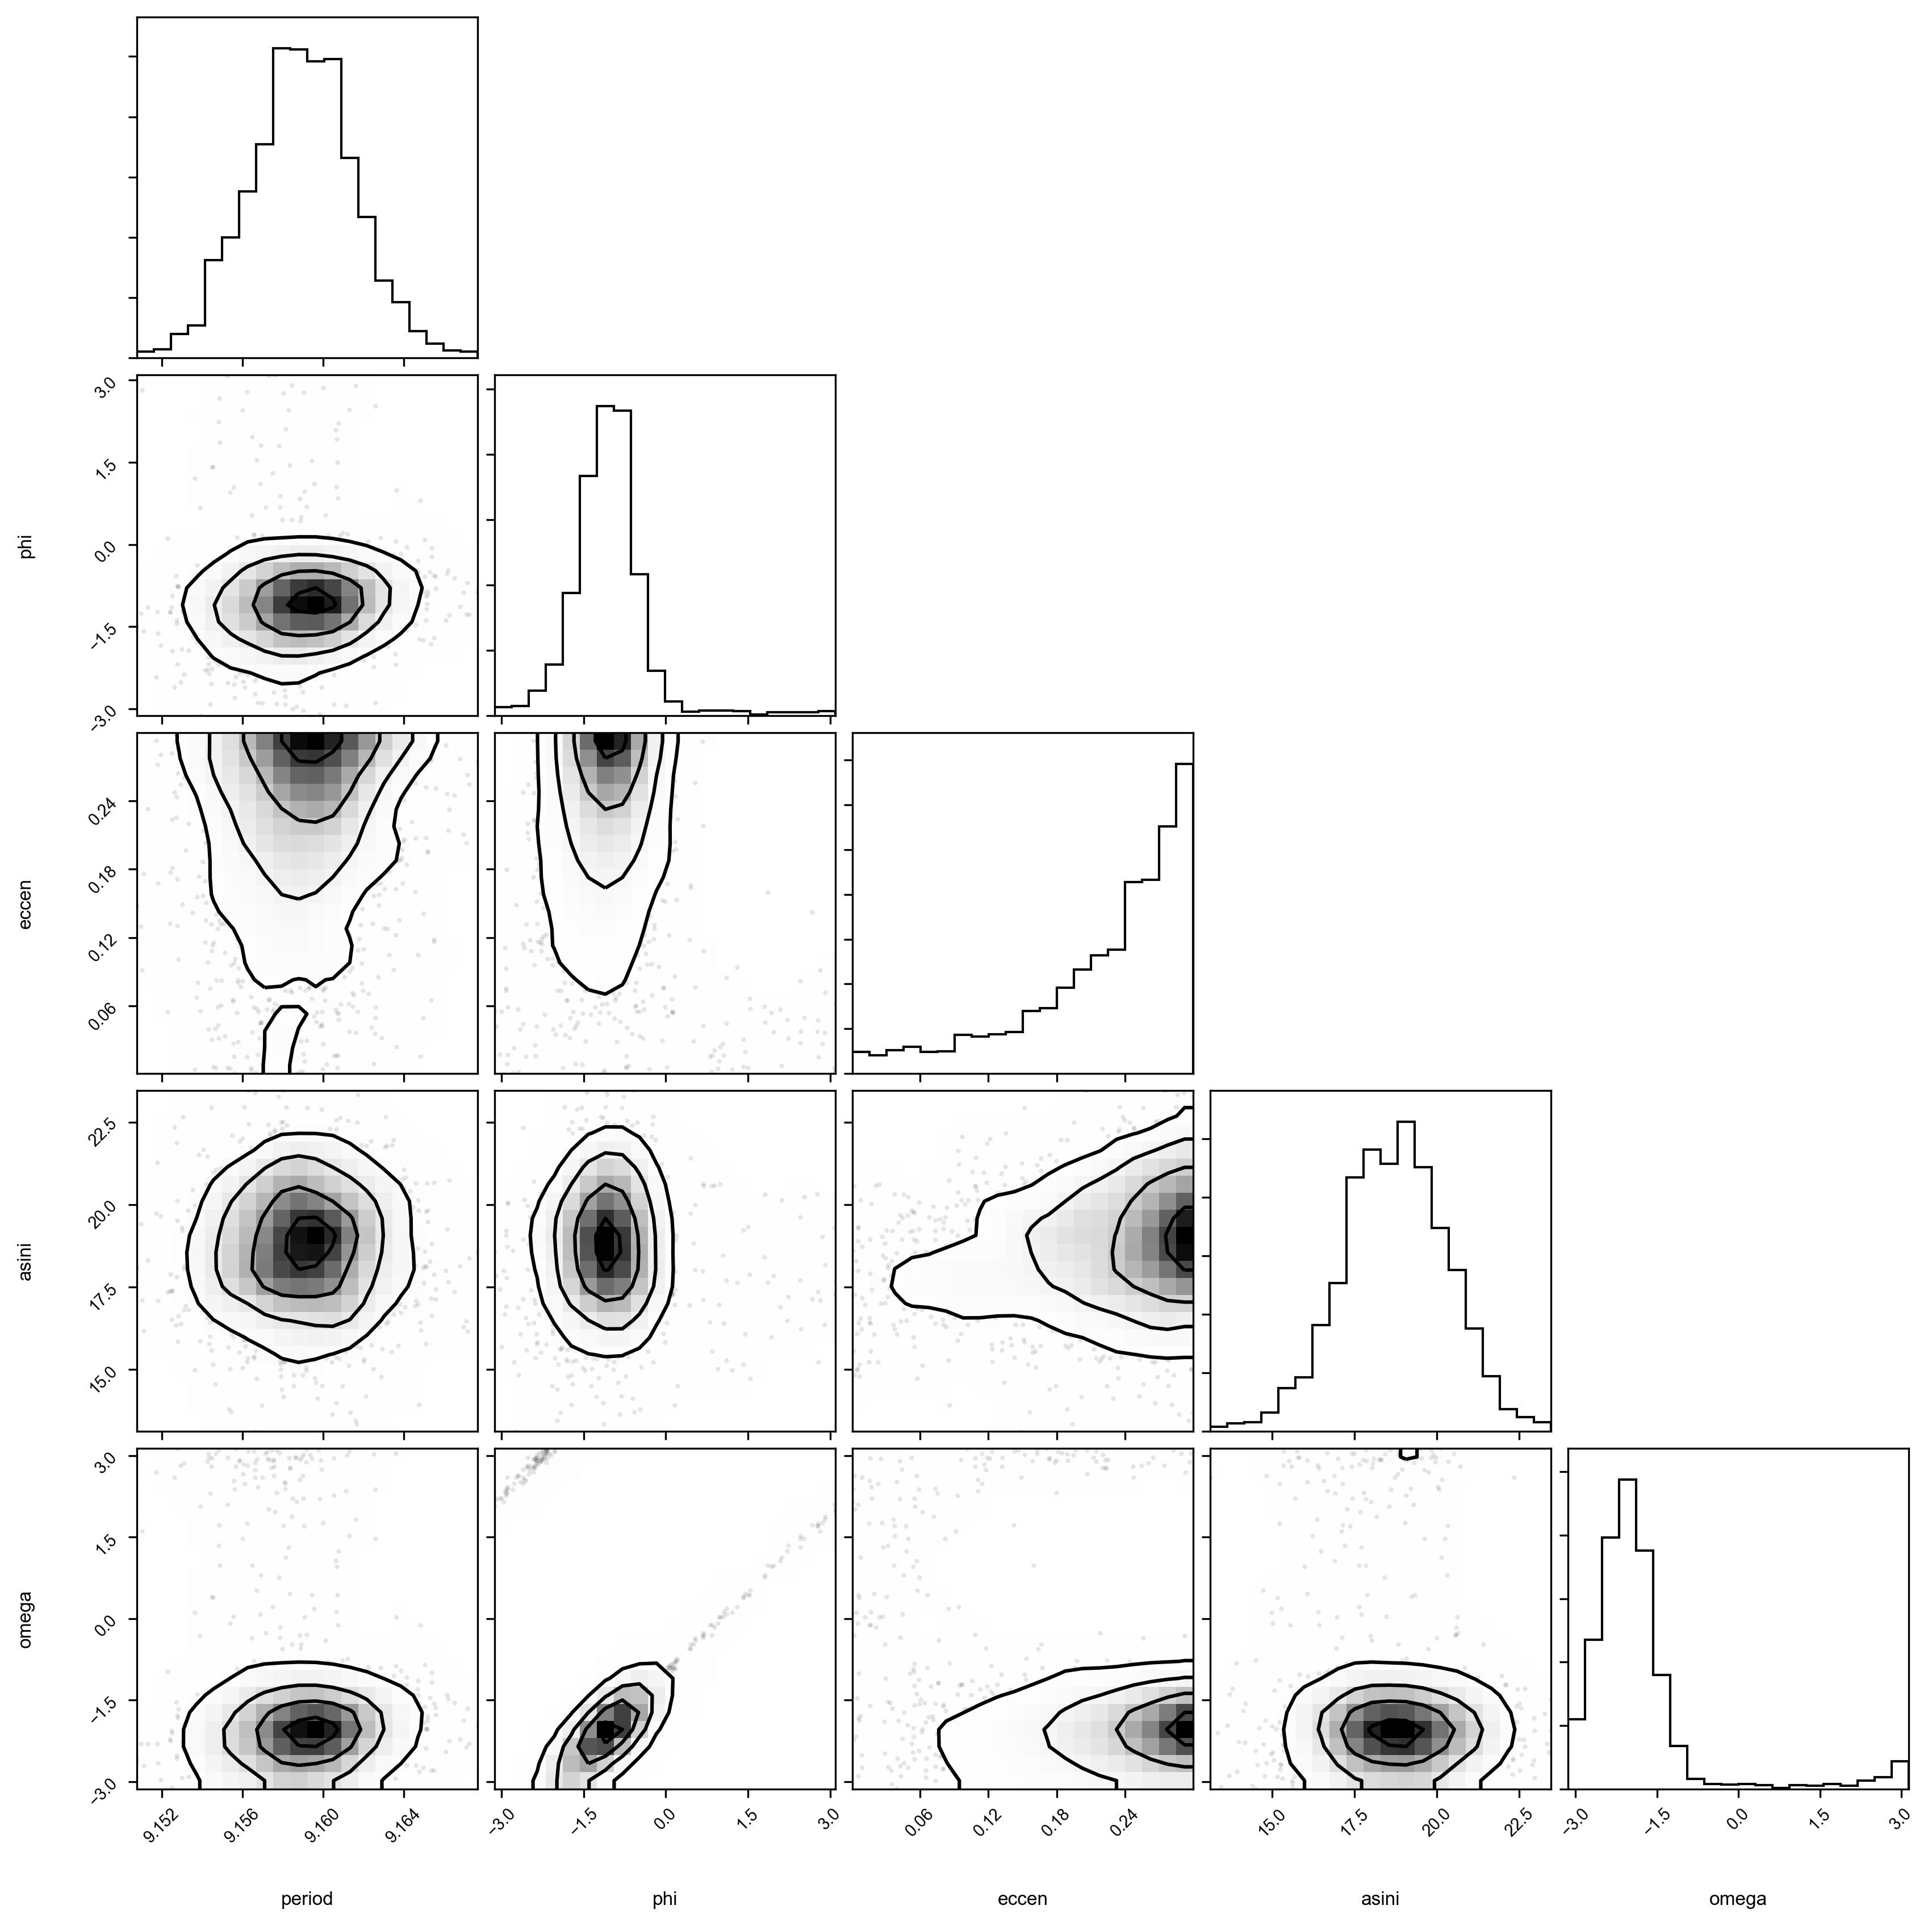

In [169]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=['period', 'phi', 'eccen', 'asini', 'omega']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples, smooth=1.);

In [37]:
samples.columns

Index(['logP', 'logasini', 'mean', 'logpower', 'period', 'phi', 'asini',
       'omega', 'eccen', 'logw0', 'logS0', 'logslc', 'lognu0', 'lognu1',
       'lognu2', 'lognu3', 'lognu4', 'nu0', 'nu1', 'nu2', 'nu3', 'nu4',
       'phase0', 'phase1', 'phase2', 'phase3', 'phase4', 'logamp0', 'logamp1',
       'logamp2', 'logamp3', 'logamp4'],
      dtype='object')

# With RV

In [120]:
rv_jd, rv_rv, rv_err = np.loadtxt('data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd += 2400000
rv_jd -= 2454833
rv_jd -= ms.time_mid

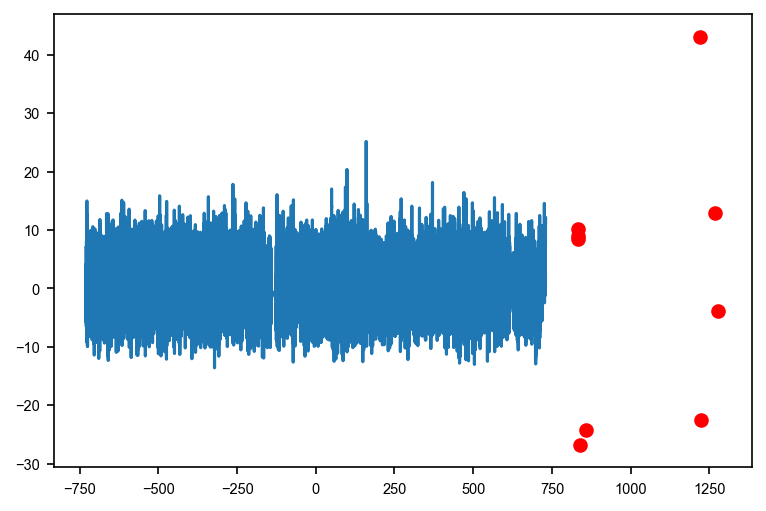

In [121]:
plt.plot(time, flux)
plt.scatter(rv_jd, rv_rv, c='r')

In [122]:
time, flux = ms.time, ms.flux
freq = ms.freq

In [128]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm
import theano

rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

weight = True

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega")
    #omega = pm.Uniform("omega", lower=0, upper=2*np.pi)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.003)

    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
                
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(flux))  # np.log(np.median(np.abs(np.diff(flux))))
    log_max_amp = np.log(np.std(flux))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    gp_l = gp.log_likelihood(flux - full_lc)
    # Weight likelihood equally with RV data
    if weight:
        pm.Potential("obs", gp_l / (len(time) / len(rv_rv_tensor.get_value()))
                    )
    else:
        pm.Potential("obs", gp_l)
    #pm.Deterministic("gp_pred", gp.predict())

    #trace = pm.load_trace(directory='traces/6780873/')
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    
    rv_vrad_a = -1 * ((asini / 86400) * (-2.0 * np.pi * (1 / period) * 
                                    (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav

    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv), observed=rv_rv_tensor.get_value())
    
    trace = pm.load_trace('traces/6780873_with_rv/')

[phi_angle__, logs_lc, mean, omega_angle__, eccen_interval__, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower, logs_RV_a, gammav]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -9190.919911529387 -> -9190.91991148364
optimizing logp for variables: ['logs_RV_a', 'logs_lc']
message: Optimization terminated successfully.
logp: -9190.91991148364 -> -109.76148216706142
optimizing logp for variables: ['gammav', 'logw0_interval__', 'logpower']
message: Optimization terminated successfully.
logp: -109.76148216706142 -> -108.2987524088284
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Optimization terminated successfully.
logp: -108.2987524088284 -> -66.14663655454649
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -66.14663655454649 -> -37.54725558630622
optimizing logp for variables: ['phi_angle__']
message: Optimization te

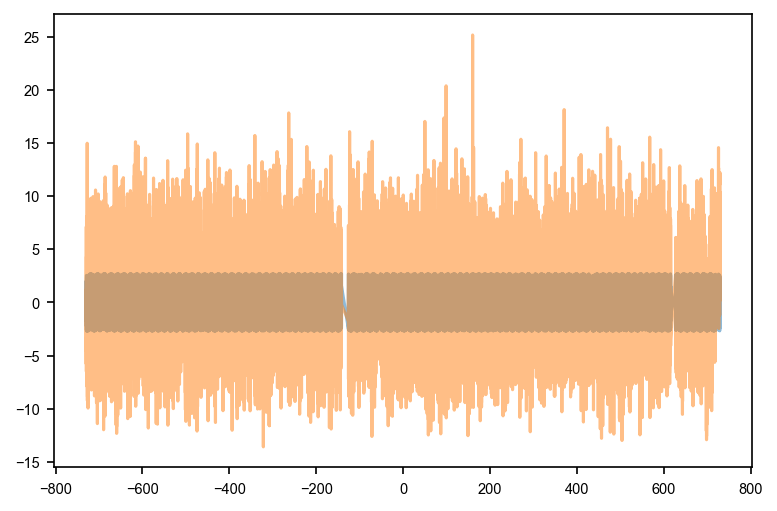

In [129]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc, logs_rv])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0, gammav])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

In [130]:
map_params

{'logP_interval__': array(-1.03326681),
 'phi_angle__': array([2.05471012, 3.972174  ]),
 'logs_lc': array(-1.26317076),
 'logasini_interval__': array(-0.33908153),
 'mean': array(0.00810569),
 'omega_angle__': array([-4.08003503,  1.83120566]),
 'eccen_interval__': array(-1.77749742),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.31384049, -2.9443834 ],
        [-3.00307529,  3.36609661]]),
 'logamp_interval__': array([ 0.58653419, -0.42135927]),
 'logw0_interval__': array(1.13966823),
 'logpower': array(10.66503559),
 'logs_RV_a': array(0.07039479),
 'gammav': array(17.85382405),
 'logP': array(2.21375426),
 'period': array(9.1500035),
 'phi': array(0.47737266),
 'logasini': array(2.97216373),
 'asini': array(19.53414058),
 'omega': array(-1.14892324),
 'eccen': array(0.14446781),
 'nu': array([14.18764151, 13.43633758]),
 'phase': array([ 2.3070384 , -0.71866994]),
 'logamp': array([ 0.54314751, -0.0241588 ]),
 'logw0': array(2.4661516),
 'logS0': array(0.8

In [124]:
with model:
    a = xo.eval_in_model(rv_vrad_a, samp)
    plt.scatter(rv_jd % 9.158737 /  9.158737, a)
    plt.scatter(rv_jd % 9.158737 /  9.158737, rv_rv)
#ax2.plot(rv_jd % 9.158737 /  9.158737, rv_rv, '.', c='black', label='RV data', rasterized=True, zorder=50, markersize=3)

#a, b = ms.get_time_delay(segment_size=1)
#plt.scatter(a + ms.time_mid,b[:,0])

#plt.savefig(overleaf_path + '6780873.png', dpi=300, bbox_inches='tight', pad_inches=0)

KeyError: 'logP_interval__'

In [ ]:
rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

In [125]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.308286,6.366680e-03,1.833004e-04,-1.320616,-1.295120,1024.339505,0.999506
mean,0.008196,4.622965e-02,9.528685e-04,-0.085180,0.095034,2810.182232,0.999793
lognu__0,2.652371,3.374757e-08,7.423939e-10,2.652371,2.652371,2539.767910,0.999723
lognu__1,2.597963,6.682023e-08,1.468468e-09,2.597963,2.597963,1906.046658,1.000455
logpower,10.823014,9.788195e-03,2.046793e-04,10.801983,10.840368,2051.955381,1.000275
logs_RV_a,0.113243,3.894240e-01,1.659209e-02,-0.573142,0.873188,536.548965,1.000780
gammav,12.028713,1.042564e+00,3.521970e-02,10.111628,14.296310,833.776563,0.999724
logP,2.214708,1.219274e-04,2.952583e-06,2.214481,2.214941,1607.791017,1.003439
period,9.158737,1.116688e-03,2.704163e-05,9.156652,9.160867,1607.789372,1.003438
phi,0.230553,4.304196e-01,1.366146e-02,-0.384270,1.091680,665.093415,0.999602


In [126]:
varnames=['period', 'asini', 'phi', 'eccen', 'omega', 'logw0', 'logS0']
rounding = 3
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
 

period :  9.159  +  0.001  -  0.001
asini :  17.364  +  0.728  -  0.729
phi :  0.22  +  0.191  -  0.169
eccen :  0.093  +  0.037  -  0.038
omega :  -0.761  +  0.192  -  0.175
logw0 :  2.628  +  0.006  -  0.006
logS0 :  0.312  +  0.021  -  0.021


In [127]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.067  +  0.009  -  0.008
